## Create model based on paper

References:   
Paper: https://arxiv.org/pdf/1312.5602.pdf    
Pytorch docs: https://arxiv.org/pdf/1312.5602.pdf

In [66]:
# import relevant packages
import torch
from collections import namedtuple, deque
import random
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import gym
import pandas as pd

### Experience Replay  

In [4]:
# Use named tuple to represent Experience referred in paper
Experience = namedtuple('Experience', ["state", "action", "reward", "successor", "done"])

class ReplayMemory():
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        """add new experience"""
        self.memory.append(Experience(*args))
        
    def sample(self, batch_size):
        """randomly sample experiences from Replay Memory"""
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        """Override default len() method"""
        return len(self.memory)

### Frame preprocessing function (referred as $\phi$ in paper)

In [5]:
def frame_preprocess(frame, prev_frames=None):
    """Preprocess frame as a stack of 4 frames
        frame: current frame
        prev_frames: array of previous frames, assumed to have len of 4
    """
    
    if not prev_frames:
        # if there is no previous frames, stack contains 4 of the same frames
        return [frame*4]
    
    return prev_frames[1:] + [frame]

### Training Model

In [58]:
class DQN_model(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN_model, self).__init__()
        self.layer1 = nn.Conv2d(input_shape[0], 32, kernel_size=(8,8), stride=4)
        self.layer2 = nn.Conv2d(32, 64, (4,4), stride=2)
        # output shape after EACH convo would be ((dimension - filter size)/stride +1) **2 (for 2 sides)
                                                                            # * 4 (stack) * output_channel
        dim_size = (((input_shape[-1]-8)/4 + 1)-4)/2+1
        self.layer3 = nn.Linear(int((dim_size)**2 * 4 * 64), 256)
        self.output = nn.Linear(256, n_actions) 
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = nn.Flatten(x)
        x = F.relu(self.layer3(x))
        x = F.relu(self.output(x))

### Prepare environment

Observation shape:  (4, 84, 84, 1)


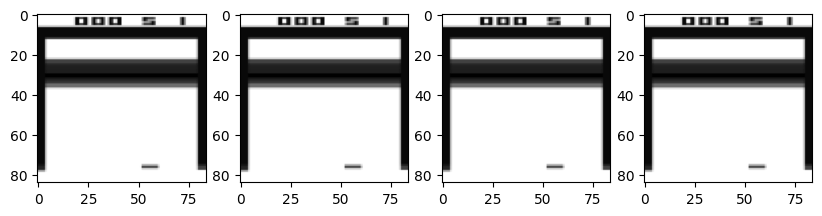

In [42]:
from gym.wrappers import GrayScaleObservation, ResizeObservation, FrameStack
from gym.utils.env_checker import check_env

def generate_env(env_name):
    env = gym.make(env_name)
    # gray scale frame
    env = GrayScaleObservation(env, keep_dim=False)
    # resize frame to 84×84 image
    env = ResizeObservation(env, (84, 84))
    # stack 4 frames (equivalent to what phi does in paper) 
    env = FrameStack(env, num_stack=4)
    
    return env
    
env = generate_env("Breakout-v4")
env.reset()
observation, reward, done, _ = env.step(env.action_space.sample())
print("Observation shape: ", env.observation_space.shape)

# visualize frames in each step 
_, axs = plt.subplots(1, 4, figsize=(10,10))
for i, image in enumerate(observation):
    axs[i].imshow(image, cmap=plt.cm.binary)
plt.show()

### Function to determine action

In [61]:
import random

def choose_action(model, state, epsilon=0.1):
    if random.random()<epsilon: #exploration
        return env.action_space.sample()
    else:
        # predict
        pred = model.forward(state)
        return env.action_space(torch.argmax(pred))

### Hyper parameters

In [62]:
LEARNING_RATE = 0.1
REPLAY_LEN = 1000000
BATCH_SIZE = 32
EPISODES = 1000
DISCOUNT = 0.7 #aka gamma in Bellman's equation
SAVE_FREQ = 100
EPSILON=0.1

### Setting up various variables

In [63]:
model = DQN_model(env.observation_space.shape, env.action_space.n)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
# loss_fn = nn.MSELoss()
def loss_fn(model, replay_memory, batch_size, discount):
    batch = replay_memory.sample(batch_size)
    
#     convert to dataframe for easy access
    batch_df = pd.dataframe(batch, columns=Experience._fields)
    
    # Tensor-ify state, action, reward, successor, done (use torch tensor to have grad)
    state = torch.Tensor(batch_df["state"])
    action = torch.Tensor(batch_df["action"])
    reward = torch.Tensor(batch_df["reward"])
    successor = torch.Tensor(batch_df["successor"])
    done = torch.Tensor(batch_df["done"])

    # use model to get old qs and new qs
    old_qs = model.forward(state)
    new_qs = model.forward(successor)
    
    # compute expected qs
    expected_qs = (reward + gamma*new_qs) if not done else reward
    
    # compute loss
    loss = (old_qs - expected_qs).pow(2).mean()
    return loss
    
# episode count
episodes = []
losses = []
reward = []

# build env
env = generate_env("Breakout-v4")

# Initialize replay memory with len of replay buffer
curr_state, _ = env.reset()
replay_memory = ReplayMemory(capacity=REPLAY_LEN)
for i in range(batch_size):
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)
    
    exp = Experience(curr_state, action, reward, observation, done)
    replay_memory.push(exp)
    
    # update curr state
    curr_state = observation

### Training process

In [64]:
# main training loop
for i in range(EPISODES):
    curr_state, _ = env.reset()
    
    while True:
        action = choose_action(model, curr_state, epsilon=EPSILON)
        # execute action
        observation, reward, done, _ = env.step(action)
        # save observation
        exp = Experience(curr_state, action, reward, observation, done)
        replay_memory.push(exp)
        
        # sample and compute loss
        loss = loss_fn(model, replay_memory, BATCH_SIZE, DISCOUNT)
        
        # zero out gradient before backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if done: 
            curr_state, _ = env.reset()
            # finish an episode
            break

### Plot loss

In [ ]:
plt.plot(episodes, reward)

### Save model

In [ ]:
with open('dqn_model.pt', 'wb') as f:
    save(model.state_dict(), f)